In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, hilbert
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile
from scipy.signal import resample

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = [5,3]
plt.rcParams['lines.linewidth'] = 1

# Function for plotting in time and frequency domain
def plot_signal(t, signal, title, Fs):
    # Time domain
    plt.subplot(2, 1, 1)
    plt.plot(t, signal)
    plt.title(title + ' - Time Domain')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    # Frequency domain
    plt.subplot(2, 1, 2)
    f = np.linspace(-Fs/2, Fs/2, len(signal))
    signal_fft = fft(signal)
    signal_fft_shifted = np.fft.fftshift(signal_fft)
    plt.plot(f, np.abs(signal_fft_shifted))
    plt.title(title + ' - Frequency Domain')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()
    
def lowpass_filter(signal, cutoff, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    return lfilter(b, a, signal)

def write_wav(filename, data, sample_rate=44100):
    # resample
    data = resample(data, int(len(data)/sample_rate * 44100))
    wavfile.write(filename, 44100, data.astype(np.int16))
    
# Bandpass filter design
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

def get_envelope(signal, message_frequency=5000, method='hilbert'):
    if method == 'hilbert':
        analytic_signal = hilbert(signal)
        envelope = np.abs(analytic_signal)
        return envelope
    b, a = butter(8, message_frequency/(Fs/2), btype='low', analog=False)
    envelope = lfilter(b, a, np.abs(signal))
    return envelope

Carrier frequency: 180000 Hz
Modulation index: 0.3
Frequency sensitivity: 0.12926577042399173 Hz/V
TX Bandwidth: 13000.0 Hz
Duration: 3.6176666666666666 s
Sampling frequency: 480000 Hz
Number of samples: 1736480


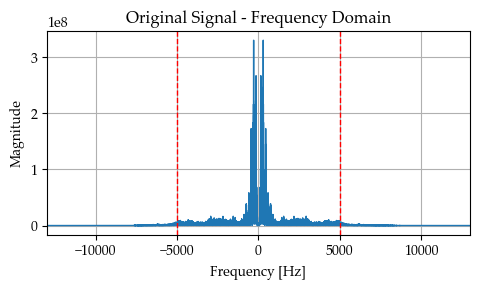

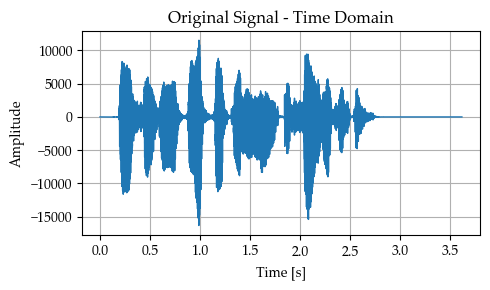

In [31]:
# Original single tone signal
# original_signal = np.cos(2 * np.pi * f_m * t) + 0.7*np.cos(2 * np.pi * 0.6*f_m * t)
f_c = 180000  # Carrier frequency 180 kHz
beta = 0.3    # Modulation index
Fs, original_signal = wavfile.read('audio.wav')
# append some zeros to the end and beginning of the signal
original_signal = np.concatenate((np.zeros(1000), original_signal, np.zeros(1000)))
write_wav('original.wav', original_signal, Fs)
Am = np.max(original_signal) # Amplitude of the message signal
fm = 5e3 # Frequency of the message signal
kf = beta*fm/Am # Frequency sensitivity
bt = 2*kf*Am + 2*fm # TX Bandwidth of the FM signal, by Carson's rule
duration = len(original_signal)/Fs

# manually upsample to 2*Fs
upsample_factor = 10
original_signal = resample(original_signal, upsample_factor*len(original_signal))
Fs *= upsample_factor
t = np.arange(0, duration, 1/Fs)

original_signal = np.copy(lowpass_filter(original_signal, cutoff=fm, sample_rate=Fs, order=8))
write_wav('original_filtered.wav', original_signal, Fs)

# print the parameters
print('Carrier frequency: {} Hz'.format(f_c))
print('Modulation index: {}'.format(beta))
print('Frequency sensitivity: {} Hz/V'.format(kf))
print('TX Bandwidth: {} Hz'.format(bt))
print('Duration: {} s'.format(duration))
print('Sampling frequency: {} Hz'.format(Fs))
print('Number of samples: {}'.format(len(original_signal)))

# Plot original signal in time and frequency domain
original_signal_fft = fftshift(fft(original_signal))
f = np.linspace(-Fs/2, Fs/2, len(original_signal))
plt.plot(f, np.abs(original_signal_fft))
plt.title('Original Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([-bt, bt])
plt.axvline(x=-fm, color='r', linestyle='--') # mark fm
plt.axvline(x=fm, color='r', linestyle='--')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, original_signal)
plt.title('Original Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()


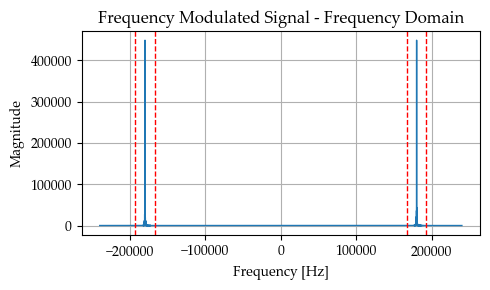

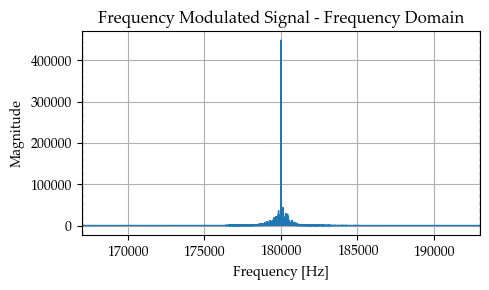

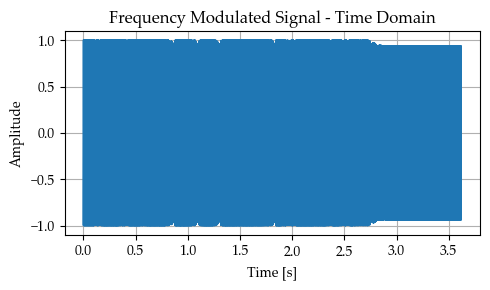

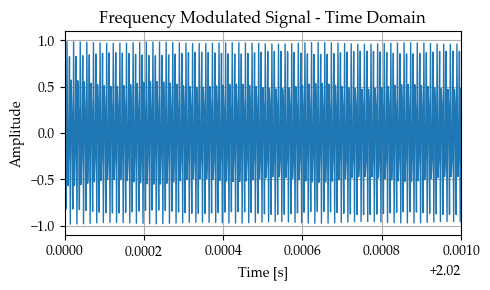

In [32]:
# FM Modulation
message_integral = np.cumsum(original_signal) / Fs

# FM modulated signal
fm_signal = np.cos(2 * np.pi * f_c * t + 2 * np.pi * kf * message_integral) # carrier amplitude = 1 by default

# Plot FM signal
fm_signal_fft = fftshift(fft(fm_signal))
f = np.linspace(-Fs/2, Fs/2, len(fm_signal))
plt.plot(f, np.abs(fm_signal_fft))
plt.title('Frequency Modulated Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
# plt.xlim([-bt, bt])
plt.axvline(x=f_c - bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=f_c + bt, color='r', linestyle='--')
plt.axvline(x=-f_c - bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=-f_c + bt, color='r', linestyle='--')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

# Plot FM signal
fm_signal_fft = fftshift(fft(fm_signal))
f = np.linspace(-Fs/2, Fs/2, len(fm_signal))
plt.plot(f, np.abs(fm_signal_fft))
plt.title('Frequency Modulated Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([f_c-bt, f_c+bt])
plt.axvline(x=f_c - bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=f_c + bt, color='r', linestyle='--')
plt.axvline(x=-f_c - bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=-f_c + bt, color='r', linestyle='--')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, fm_signal)
plt.title('Frequency Modulated Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, fm_signal)
plt.title('Frequency Modulated Signal - Time Domain')
plt.xlabel('Time [s]')
plt.xlim([2.02, 2.021])
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

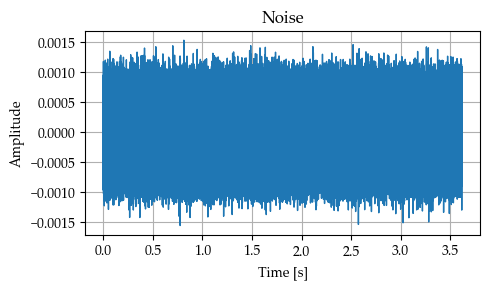

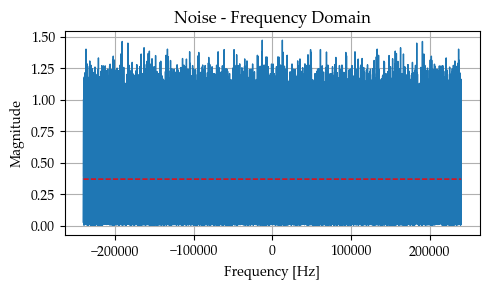

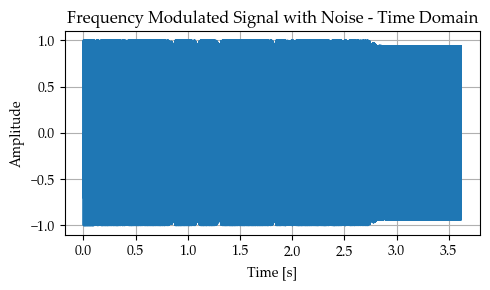

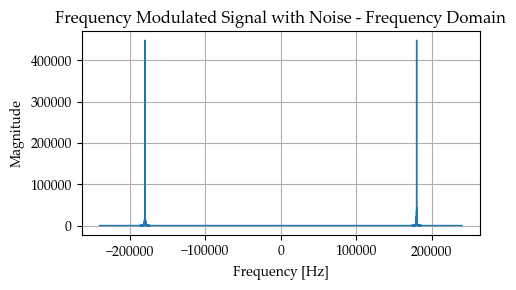

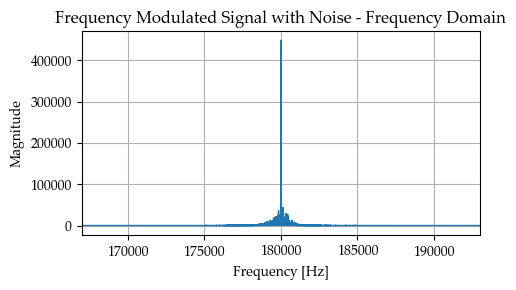

Noise variance: 1.0004658827337721e-07
Noise mean: -1.264411755086801e-07
Noise average power density: 0.36946157800778057
N0: 3.0788464833981714e-06


In [33]:
# Add AWGN noise to the FM signal
noise_variance = 0.0000001
noise = np.sqrt(noise_variance) * np.random.randn(len(t))
noise_fft = fftshift(fft(noise))
f = np.linspace(-Fs/2, Fs/2, len(noise))
fm_signal_noisy = fm_signal + noise
fm_signal_noisy_fft = fftshift(fft(fm_signal_noisy))

# plot noise
plt.figure()
plt.plot(t, noise)
plt.title('Noise')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# plot noise in frequency domain
plt.figure()
plt.plot(f, np.abs(noise_fft))
plt.plot(f, np.mean(np.abs(noise_fft))*np.ones(len(f)), 'r--')
plt.title('Noise - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

# Plot FM signal with noise
plt.figure()
plt.plot(t, fm_signal_noisy)
plt.title('Frequency Modulated Signal with Noise - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot FM signal with noise in frequency domain
plt.figure()
plt.plot(f, np.abs(fm_signal_noisy_fft))
plt.title('Frequency Modulated Signal with Noise - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(fm_signal_noisy_fft))
plt.title('Frequency Modulated Signal with Noise - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([f_c-bt, f_c+bt])
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

N0 = np.mean(np.abs(noise_fft)) * 4 / Fs

print('Noise variance: {}'.format(np.var(noise)))
print('Noise mean: {}'.format(np.mean(noise)))
print('Noise average power density: {}'.format(np.mean(np.abs(noise_fft))))
print('N0: {}'.format(N0))

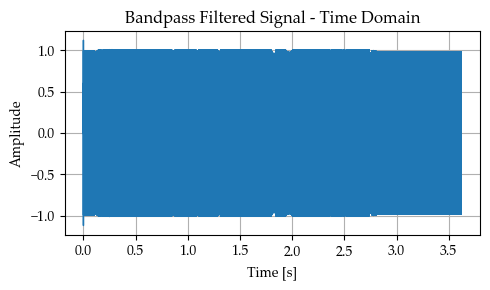

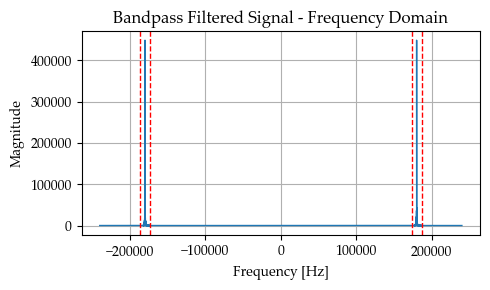

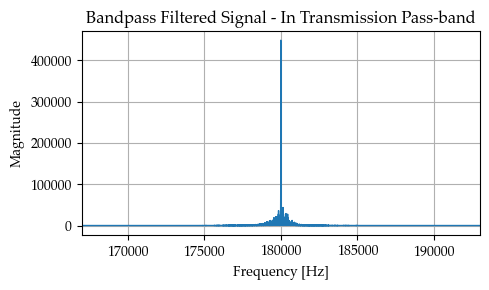

In [34]:
# Apply bandpass filter
bp_filtered_signal = bandpass_filter(fm_signal_noisy, f_c - 0.5*bt, f_c + 0.5*bt, Fs)
bp_filtered_signal_fft = fftshift(fft(bp_filtered_signal))
f = np.linspace(-Fs/2, Fs/2, len(bp_filtered_signal))

# Plot bandpass filtered signal
plt.figure()
plt.plot(t, bp_filtered_signal)
plt.title('Bandpass Filtered Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot bandpass filtered signal in frequency domain
plt.figure()
plt.plot(f, np.abs(bp_filtered_signal_fft))
plt.title('Bandpass Filtered Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.axvline(x=f_c - 0.5*bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=f_c + 0.5*bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=-f_c - 0.5*bt, color='r', linestyle='--') # mark tx bandwidth
plt.axvline(x=-f_c + 0.5*bt, color='r', linestyle='--') # mark tx bandwidth
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(bp_filtered_signal_fft))
plt.title('Bandpass Filtered Signal - In Transmission Pass-band')
plt.xlabel('Frequency [Hz]')
plt.xlim([f_c-bt, f_c+bt])
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

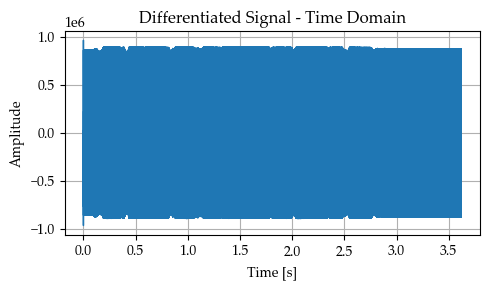

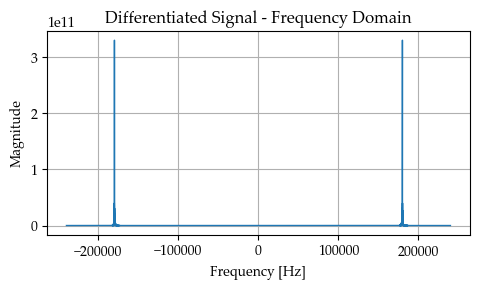

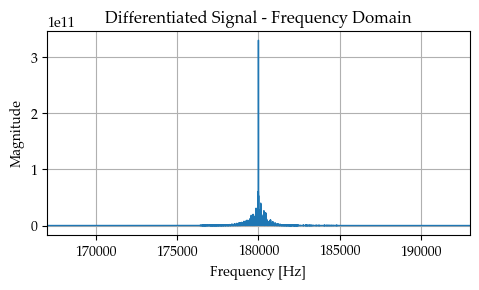

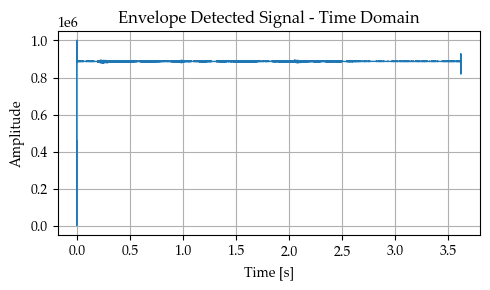

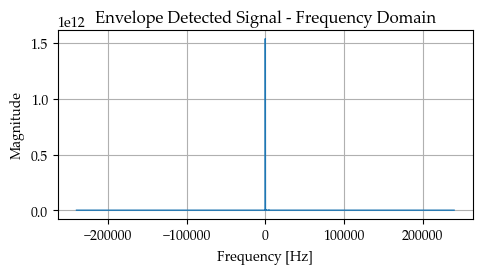

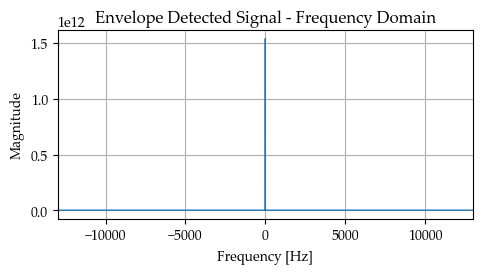

In [35]:
# Corrected Differentiation of the signal
# The differentiated signal should be one element shorter, so we adjust the time array accordingly
differentiated_signal = np.diff(bp_filtered_signal) / np.diff(t)
t_diff = np.arange(0, len(differentiated_signal)/Fs, 1/Fs)

# Plot differentiated signal with corrected time array
plt.figure()
plt.plot(t_diff, differentiated_signal)
plt.title('Differentiated Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot differentiated signal with corrected time array
differentiated_signal_fft = fftshift(fft(differentiated_signal))
f = np.linspace(-Fs/2, Fs/2, len(differentiated_signal))
plt.figure()
plt.plot(f, np.abs(differentiated_signal_fft))
plt.title('Differentiated Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(differentiated_signal_fft))
plt.title('Differentiated Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([f_c-bt, f_c+bt])
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


# Envelope detection using the Hilbert transform on the corrected differentiated signal
envelope = get_envelope(differentiated_signal, fm, method='hilbert')
envelope_fft = fftshift(fft(envelope))
f = np.linspace(-Fs/2, Fs/2, len(envelope))

plt.figure()
plt.plot(t_diff, envelope)
plt.title('Envelope Detected Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(envelope_fft))
plt.title('Envelope Detected Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(envelope_fft))
plt.title('Envelope Detected Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([-bt, bt])
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()


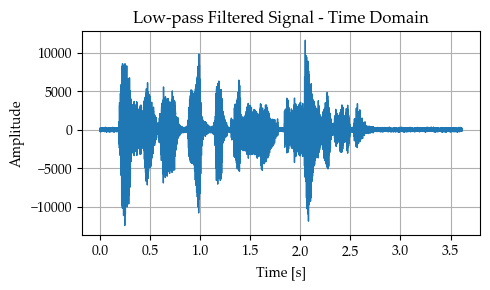

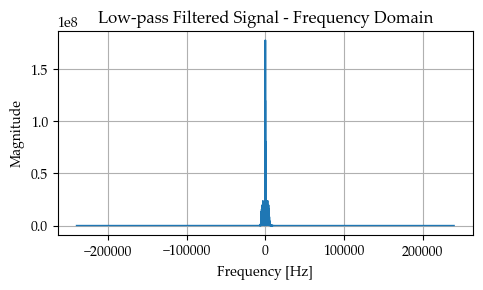

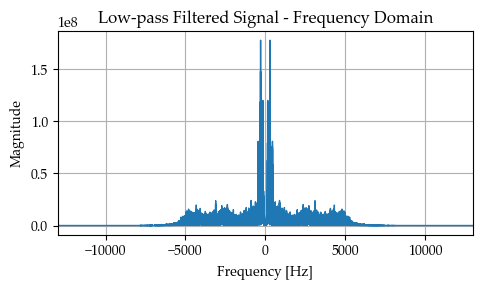

In [36]:

# Apply low-pass filter on the envelope detected signal
lp_filtered_signal = lowpass_filter(envelope, fm, Fs, 8)

# remove the first and last 1000 samples
lp_filtered_signal = lp_filtered_signal[1000:-1000]
t = np.arange(0, len(lp_filtered_signal)/Fs, 1/Fs)

# dc blocking
lp_filtered_signal = np.copy(lp_filtered_signal - np.mean(lp_filtered_signal))

# match gain
lp_filtered_signal = np.copy(lp_filtered_signal / np.max(lp_filtered_signal) * Am)
t_diff = np.arange(0, len(lp_filtered_signal)/Fs, 1/Fs)
write_wav('fm_demodulated.wav', lp_filtered_signal, Fs)

# Plot low-pass filtered signal with corrected time array
plt.figure()
plt.plot(t_diff, lp_filtered_signal)
plt.title('Low-pass Filtered Signal - Time Domain')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot low-pass filtered signal with corrected time array
lp_filtered_signal_fft = fftshift(fft(lp_filtered_signal))
f = np.linspace(-Fs/2, Fs/2, len(lp_filtered_signal))
plt.figure()
plt.plot(f, np.abs(lp_filtered_signal_fft))
plt.title('Low-pass Filtered Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(f, np.abs(lp_filtered_signal_fft))
plt.title('Low-pass Filtered Signal - Frequency Domain')
plt.xlabel('Frequency [Hz]')
plt.xlim([-bt, bt])
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()